# Explore Neural networks, regularization methods and SGD methods

The questions I am to answer are:
- how many neurons are ideal in hidden layer?
- deep and narrow vs shallow and wide networks
- differnet activation functions
- does batchnorm makes a difference?

### Setup

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
from sklearn.datasets import fetch_mldata
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from IPython.display import display, clear_output
from tqdm import tqdm as tqdm

## Data Loading

In [2]:
ds_train = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
train_loader = torch.utils.data.DataLoader(ds_train,batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32, shuffle=True)

## Logistic Regression Baseline

Same as from yesterday's excercise except we use the pytorch declarative api for it

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [4]:
d_in = 784

Train

In [5]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    correct = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        loss += criterion(a_out, labels).item() * labels.shape[0]
        correct += (yh == labels).sum().item()
        num += labels.shape[0]
    #print(f"Validation Loss: {loss/num} accuracy: {correct/num}")
    return loss/num, correct/num

In [61]:
def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, val_acc = [], []
    r_loss, c_loss, r_num = 0, 0, 0
    for e in range(epochs):
        if lrs is not None: lrs.step()
        for inputs, labels in train_loader:
            
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            logits = model(inputs)

            loss = criterion(logits, labels)
            
            r_num += 1
            c_loss = 0.9 * c_loss + 0.1 * loss.item()

            loss.backward()
            optimizer.step()
        vloss, vacc = get_validation_error(model)
        print(f"epoch: {e + 1} running loss {c_loss} accuracy: {vacc}")
        val_loss.append(vloss), val_acc.append(vacc)
    return pd.DataFrame({'loss': val_loss, 'acc': val_acc})
        

In [62]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 10)
)

In [63]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=7, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10
stats_lr = train(model, optimizer, criterion, epochs, None)  

epoch: 1 running loss 0.823794053044649 accuracy: 0.8965
epoch: 2 running loss 0.7874682634380933 accuracy: 0.8903
epoch: 3 running loss 0.7713022423791964 accuracy: 0.8841
epoch: 4 running loss 0.8221593438854237 accuracy: 0.8938
epoch: 5 running loss 0.8713962908647419 accuracy: 0.8778
epoch: 6 running loss 0.6154897537111323 accuracy: 0.8761
epoch: 7 running loss 0.607485014342501 accuracy: 0.898
epoch: 8 running loss 0.5496875716483369 accuracy: 0.9103
epoch: 9 running loss 0.733021413491816 accuracy: 0.9036
epoch: 10 running loss 0.7805477250491928 accuracy: 0.902


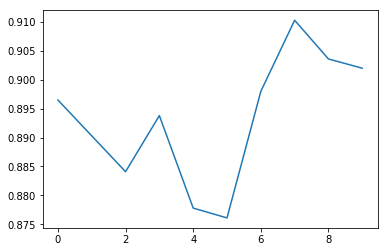

In [64]:
plt.plot(range(epochs), stats_lr['acc'], '-')

In [65]:
stats_lr.tail()

,loss,acc
5,1.004846,0.8761
6,0.796146,0.8980
7,0.686836,0.9103
8,0.780663,0.9036
9,0.852804,0.9020


Pretty cool, we can get up to 97.5% accuracy using just a plain logistic regression!! this is not a very hard NN problem it seems...

## 1  hidden layer

In [69]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 200),
    nn.Dropout(0.3),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)

In [70]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 20
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(epochs), stats_lr['acc'], '-')

epoch: 1 running loss 0.21254192138038394 accuracy: 0.9365
epoch: 2 running loss 0.4293271340422364 accuracy: 0.9386
epoch: 3 running loss 0.3841691489041516 accuracy: 0.9298
epoch: 4 running loss 0.40909780520010813 accuracy: 0.9375
epoch: 5 running loss 0.19888548649717755 accuracy: 0.9427
epoch: 6 running loss 0.3937048292718236 accuracy: 0.9325
epoch: 7 running loss 0.2660536081344311 accuracy: 0.9501
epoch: 8 running loss 0.3403174798384288 accuracy: 0.9414
epoch: 9 running loss 0.25803493058149823 accuracy: 0.9445
epoch: 10 running loss 0.2738031043855263 accuracy: 0.9466


KeyboardInterrupt: 

In [ ]:
stats_lr.tail()

100.00% accuracy is not bad .... clearly this problem is just too simple...

In [88]:
datasets.FashionMNIST

torchvision.datasets.mnist.FashionMNIST

## Fashion MNIST

In [99]:
ds_train = datasets.FashionMNIST('../data/fashionmnist', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.RandomRotation(10),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
train_loader = torch.utils.data.DataLoader(ds_train,batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data/fashionmnist', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32, shuffle=True)

In [100]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 200),
    nn.Dropout(0.3),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)

epoch: 1 running loss 0.4930719771750245 accuracy: 0.8372
epoch: 2 running loss 0.4521394692400027 accuracy: 0.8228
epoch: 3 running loss 0.4777784603773968 accuracy: 0.8429
epoch: 4 running loss 0.42640634521690035 accuracy: 0.8486
epoch: 5 running loss 0.39028561886945173 accuracy: 0.857
epoch: 6 running loss 0.44143086861443837 accuracy: 0.8644
epoch: 7 running loss 0.346175415626436 accuracy: 0.8626
epoch: 8 running loss 0.42350508655802704 accuracy: 0.8674
epoch: 9 running loss 0.3689940709475345 accuracy: 0.8677
epoch: 10 running loss 0.4354818288712917 accuracy: 0.8699
epoch: 11 running loss 0.3656544770833038 accuracy: 0.8689
epoch: 12 running loss 0.4306502980376867 accuracy: 0.8679
epoch: 13 running loss 0.3612021414915339 accuracy: 0.8751
epoch: 14 running loss 0.40940304236408614 accuracy: 0.86
epoch: 15 running loss 0.45677814555910984 accuracy: 0.8717
epoch: 16 running loss 0.30990080870575126 accuracy: 0.8711
epoch: 17 running loss 0.32779313226388895 accuracy: 0.8705
ep

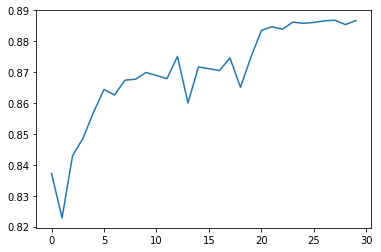

In [77]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(30), stats_lr['acc'], '-')

In [78]:
stats_lr.tail()

,loss,acc
25,0.326446,0.8861
26,0.327509,0.8866
27,0.326418,0.8868
28,0.327361,0.8854
29,0.324587,0.8867


## Investigate effect of batchnorm

In [95]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 200),
    #nn.Dropout(0.1),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)

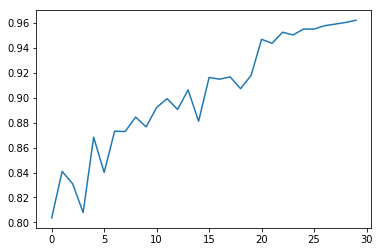

In [96]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(30), stats_lr['acc'], '-')

In [97]:
stats_lr.tail()

,acc,loss
25,0.9551,0.124318
26,0.9578,0.122056
27,0.9591,0.119570
28,0.9604,0.115545
29,0.9622,0.110927


NICE!!! batch norm boosts val accuracy to 0.96

## Investigate effect of dropout

In [113]:
drops = []
accs = []
for dropout in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f"training for dropout {dropout}")
    model = nn.Sequential(
        Flatten(),
        nn.Linear(d_in, 400),
        nn.Dropout(dropout),
        nn.LeakyReLU(),
        nn.BatchNorm1d(400),
        nn.Linear(400, 10)
    )
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    lrs = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    epochs = 20
    stats_lr = train(model, optimizer, criterion, epochs, lrs)  
    acc = stats_lr.iloc[-1].acc
    drops.append(dropout)
    accs.append(acc)
df_dropout = pd.DataFrame({'dropout': drops, 'acc': accs})

training for dropout 0
training for dropout 0.1
training for dropout 0.2
training for dropout 0.3
training for dropout 0.4
training for dropout 0.5


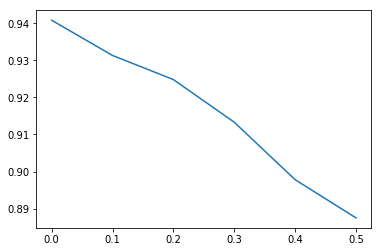

In [114]:
plt.plot(df_dropout['dropout'], df_dropout['acc'])

In [115]:
df_dropout

,acc,dropout
0,0.9408,0.0
1,0.9313,0.1
2,0.9248,0.2
3,0.9133,0.3
4,0.8978,0.4
5,0.8875,0.5


Dropout definitely seems to make things a lot worse here... interesting. Lets try train a convnet and see what happens!

## Convnet

In [154]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [106]:
model = nn.Sequential(
        # conv block 1
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2, 2),
        
        # conf block 2
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
    
      
    
    # conf block 3
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        
        # 1x1 convolution
        nn.Conv2d(32, 10, kernel_size=1),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.AdaptiveAvgPool2d((1,1)),
        
        # fc layers
        Flatten()
    )

In [107]:
xtest = next(iter(train_loader))[0]

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f7e1c356518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 153, in rec

In [ ]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(epochs), stats_lr['acc'], '-')

epoch: 1 running loss 0.5178256613394023 accuracy: 0.8655
epoch: 2 running loss 0.4378877995532548 accuracy: 0.8979
epoch: 3 running loss 0.3767284255101327 accuracy: 0.8945
epoch: 4 running loss 0.27638595320920084 accuracy: 0.9012
epoch: 5 running loss 0.31080200339077424 accuracy: 0.9056
epoch: 6 running loss 0.3010614402652607 accuracy: 0.9156
epoch: 7 running loss 0.2798669948003878 accuracy: 0.9115
epoch: 8 running loss 0.244460193139913 accuracy: 0.9142
epoch: 9 running loss 0.30435126670553747 accuracy: 0.9162
epoch: 10 running loss 0.26310579669257267 accuracy: 0.9137


In [84]:
stats_lr.tail()

,loss,acc
5,0.219570,0.9207
6,0.214990,0.9227
7,0.223906,0.9211
8,0.218646,0.9245
9,0.213242,0.9288


Pretty much piece of cake when using an CNN... I like this fully convolutional architecture =)